# Import libraries

In [ ]:

import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
import torch
from sklearn.metrics import accuracy_score, f1_score
import os

In [ ]:
# Install the arabert preprocessor package
!pip install arabert

# Also install other dependencies you'll need
!pip install transformers torch datasets scikit-learn

# Load dataset

In [ ]:
def load_data(file_path):
    dataset = pd.read_csv(file_path)
    df = pd.DataFrame(dataset, columns=['text', 'polarization'])
    print(f"Number of instances: {len(df)}")
    print(f"Label distribution:\n{df['polarization'].value_counts()}")
    return df,dataset

df , dataset = load_data("/content/fixed_file.csv")

Number of instances: 3380
Label distribution:
polarization
0    1868
1    1512
Name: count, dtype: int64


# Data agumentation

In [ ]:
import pandas as pd
import random

# قاموس مرادفات صغير
synonyms_dict = {
    "جيد": ["ممتاز", "حسن", "رائع", "عظيم", "راقي"],
    "سيء": ["رديء", "ضعيف", "سئ", "مخزي", "فاشل"],
    "سعيد": ["فرحان", "مسرور", "مبسوط", "هانئ", "مرتاح"],
    "حزين": ["كئيب", "مكتئب", "مغتاظ", "حزين", "متألم"],
    "جميل": ["حسن", "بهي", "فاتن", "رائع", "جذاب"],
    "قبيح": ["دميم", "بشع", "مقزز", "مقرف", "سيئ"],
    "كبير": ["عظيم", "ضخم", "هائل", "عريض", "واسع"],
    "صغير": ["صغير", "ضئيل", "دقيق", "صغير الحجم"],
    "ذكي": ["نبيها", "فطين", "عاقل", "حكيم"],
    "غبي": ["أحمق", "ساذج", "بليد", "تافه"],
}

#  Synonym Replacement
def synonym_replacement(text, n_replacements=1):
    words = text.split()
    new_words = words.copy()
    candidates = [i for i, w in enumerate(words) if w in synonyms_dict]
    random.shuffle(candidates)
    n_replace = min(n_replacements, len(candidates))
    for i in candidates[:n_replace]:
        new_words[i] = random.choice(synonyms_dict[words[i]])
    return " ".join(new_words)

# Data Augmentation
augmented_texts = []
augmented_labels = []

for _, row in df.iterrows():
    text = row['text']
    label = row['polarization']

    augmented_texts.append(text)
    augmented_labels.append(label)

    # 1-3 نسخ جديدة لكل مثال
    n_copies = random.randint(1, 3)
    for _ in range(n_copies):
        n_words_replace = random.randint(1, 3)
        new_text = synonym_replacement(text, n_replacements=n_words_replace)
        if new_text != text:  # نتجنب التكرار
            augmented_texts.append(new_text)
            augmented_labels.append(label)

# تجميع الداتا الجديدة
aug_df = pd.DataFrame({
    "text": augmented_texts,
    "polarization": augmented_labels
})

print(f"Original size: {len(df)}")
print(f"Augmented size: {len(aug_df)}")
aug_df.head()


Original size: 3380
Augmented size: 6032


,text,polarization
0,احلام انتي ونعالي ومنو انتي حتى تقيمين الفناني...,1
1,وره الكواليس تنيجج من وره بعير صطناعي على فكرة...,1
2,.خخخخ الملكه احلام فيها شذوذ شنو هل بوس والدلع...,1
3,الله يخزي احلام هي والبرنامج الخايس الي كله مصخره,1
4,كس ام احلام الي ماربتها وش ملكه هههه متستاهل م...,1


# load the model

In [ ]:
from arabert.preprocess import ArabertPreprocessor

MODEL_NAME = "aubmindlab/bert-base-arabertv2"
preprocessor = ArabertPreprocessor(MODEL_NAME)



[2026-01-26 17:34:10,094 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


**Data spliting**

In [ ]:
train_df, val_df = train_test_split(
    aug_df,
    test_size=0.15,
    stratify=aug_df["polarization"],
    random_state=42
)

# 2. Preprocess
train_df["cleaned_text"] = train_df["text"].apply(preprocessor.preprocess)
val_df["cleaned_text"]   = val_df["text"].apply(preprocessor.preprocess)


In [ ]:
train_df.head()

,text,polarization,cleaned_text
748,انت مريض نفسيا قاعد تنشر ع كل من هب وذب وترمي...,0,أنت مريض نفسي +ا قاعد تنشر ع كل من هب و+ ذب و+...
2797,الملك سلمان: نعتز بذكرى التأسيس ولا يزال نهجنا...,0,ال+ ملك سلمان : نعتز ب+ ذكرى ال+ تأسيس و+ لا ي...
2050,جرائم سوداء لم ترتكبها بيديك...!!!\nولكنك تبرر...,0,جرائم سوداء لم ترتكب +ها ب+ يد +ي +ك . . ! ! و...
3392,هاد روسيا عم تدعمهم من تحت الطاولة !! هم ما مع...,1,هاد روسيا عم تدعم +هم من تحت ال+ طاول +ة ! ! ه...
585,هو كل المزعييين اللى عايزين يشتهرو يستضيفو الن...,0,هو كل ال+ مزعي +ين اللي عايز +ين يشتهرو يستضيف...


In [ ]:
val_df.head()

,text,polarization,cleaned_text
4098,عندما يمثل النادي شعبا كاملا وبعبر عن قضيته \n...,0,عندما يمثل ال+ نادي شعب +ا كامل +ا و+ ب+ عبر ع...
2820,خليجي 26: ما هي المنتخبات المشاركة وما حظوظها ...,0,خليجي 26 : ما هي ال+ منتخب +ات ال+ مشارك +ة و+...
2442,شركات ناشئة أوروبية تطالب بتوحيد الجهود في مجا...,0,شرك +ات ناشئ +ة أوروبي +ة تطالب ب+ توحيد ال+ ج...
2671,وكالة شؤون الأفواج الأمنية تحتفي بيوم التأسيس,0,وكال +ة شؤون ال+ أفواج ال+ أمني +ة تحتفي ب+ يو...
5262,لاعب جديد يزاحم نوليتو على تعويض بيدرو في برشل...,0,لاعب جديد يزاحم نوليتو على تعويض بيدرو في برشل...


**Tokenization**

In [ ]:
from transformers import AutoTokenizer
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df[["cleaned_text", "polarization"]])
val_dataset   = Dataset.from_pandas(val_df[["cleaned_text", "polarization"]])

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(
        batch["cleaned_text"],
        padding="max_length",
        truncation=True,
        max_length=256 #256
    )

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset   = val_dataset.map(tokenize, batched=True)


Map:   0%|          | 0/5127 [00:00<?, ? examples/s]

Map:   0%|          | 0/905 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2  # polarization: 0 / 1
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = train_dataset.rename_column("polarization", "labels")
val_dataset   = val_dataset.rename_column("polarization", "labels")
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


In [ ]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

training_args = TrainingArguments(
    output_dir="./arabert_polarization",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32, #32
    per_device_eval_batch_size=16,
    num_train_epochs=6,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)




/tmp/ipython-input-475251045.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 31}.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.300725,0.883978,0.883882
2,No log,0.250309,0.904972,0.904279
3,No log,0.244801,0.923757,0.923504
4,0.240600,0.272918,0.932597,0.932299
5,0.240600,0.302011,0.939227,0.939108
6,0.240600,0.304252,0.935912,0.935707


TrainOutput(global_step=966, training_loss=0.14195895540541498, metrics={'train_runtime': 520.2864, 'train_samples_per_second': 59.125, 'train_steps_per_second': 1.857, 'total_flos': 4046911142492160.0, 'train_loss': 0.14195895540541498, 'epoch': 6.0})


Evaluating AraBERTv2



Classification Report:
                   precision    recall  f1-score   support

Non-polarized (0)       0.94      0.94      0.94       474
    Polarized (1)       0.93      0.94      0.94       431

         accuracy                           0.94       905
        macro avg       0.94      0.94      0.94       905
     weighted avg       0.94      0.94      0.94       905



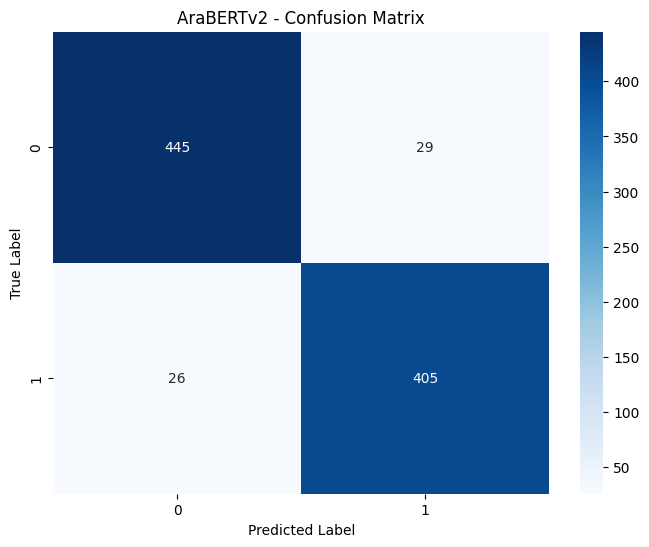


Results for AraBERTv2:
Accuracy     : 0.9392
F1-macro     : 0.9391
F1-weighted  : 0.9392

Final Summary - AraBERTv2:
Accuracy: 0.9392
F1-macro: 0.9391


In [ ]:

import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def evaluate_model(trainer, test_dataset, model_name="Model"):
    print(f"\n{'='*80}")
    print(f"Evaluating {model_name}")
    print(f"{'='*80}")

    predictions = trainer.predict(test_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    #  تقرير مفصل
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=['Non-polarized (0)', 'Polarized (1)']))

    # رسم confusion matrix
    plot_confusion_matrix(labels, preds, title=f"{model_name} - Confusion Matrix")

    results = {
        'accuracy': accuracy_score(labels, preds),
        'f1_macro': f1_score(labels, preds, average='macro'),
        'f1_weighted': f1_score(labels, preds, average='weighted')
    }

    print(f"\nResults for {model_name}:")
    print(f"Accuracy     : {results['accuracy']:.4f}")
    print(f"F1-macro     : {results['f1_macro']:.4f}")
    print(f"F1-weighted  : {results['f1_weighted']:.4f}")

    return results, predictions

arabertv2_results, arabertv2_preds = evaluate_model(
    trainer=trainer,
    test_dataset=val_dataset,
    model_name="AraBERTv2"
)

# لو عايز تطبع النتايج تاني أو تستخدمها
print("\nFinal Summary - AraBERTv2:")
print(f"Accuracy: {arabertv2_results['accuracy']:.4f}")
print(f"F1-macro: {arabertv2_results['f1_macro']:.4f}")

In [ ]:
from bertviz import head_view
from transformers import AutoTokenizer, AutoModel


sentence = "يسدد شباب الامة يبدد تضليل الطواغيت"
inputs = tokenizer(sentence, return_tensors='pt').to(model.device)
outputs = model(**inputs, output_attentions=True)
attentions = outputs.attentions

head_view(attentions, tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))


<IPython.core.display.Javascript object>

# load test test

In [ ]:
import pandas as pd

dev_df = pd.read_csv("/content/arb.csv")


In [ ]:
print(len(dev_df))


1521


In [ ]:
dev_df["text"] = dev_df["text"].astype(str)
dev_df["text"] = dev_df["text"].apply(clean_text_arabert)
dev_df["cleaned_text"] = dev_df["text"].apply(preprocessor.preprocess)

In [ ]:
from datasets import Dataset

dev_dataset = Dataset.from_pandas(dev_df[["cleaned_text"]])

def tokenize(batch):
    return tokenizer(
        batch["cleaned_text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

dev_dataset = dev_dataset.map(tokenize, batched=True)
dev_dataset.set_format("torch", columns=["input_ids", "attention_mask"])


Map:   0%|          | 0/1521 [00:00<?, ? examples/s]

In [ ]:
preds = trainer.predict(dev_dataset)
pred_labels = preds.predictions.argmax(-1)  # predicted polarization labels


In [ ]:
#  Save CSV for Codabench
submission = pd.DataFrame({
    "id": dev_df["id"],
    "polarization": pred_labels
})

submission.to_csv("pred_arb2.csv", index=False)
print("Saved predictions_codabench.csv ✅")

Saved predictions_codabench.csv ✅
